In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: sahaana (use `wandb login --relogin` to force relogin)


True

# Imports 

In [248]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [283]:
import sys
#sys.path.append('/lfs/1/sahaana/enrichment/enrich/utils')
sys.path.append('/lfs/1/sahaana/enrichment/ember/utils')
 
    
from embedding_datasets import DeepMatcherDataset, EmberEvalDataset
from embedding_models import TripletSingleBERTModel
from embedding_utils import param_header, tokenize_batch  
from embedding_runner import train_model, eval_model
#from model_utils import MatchedDatasetTriplets, param_header_bert, tokenize_batch   
#from models import BatchedTripletSingleTowerModel, BatchedTripletSingleBERTModel
#from model_runner import train_model, eval_model
from knn_utils import FaissKNeighbors, knn_top_1_PRFS #, knn_matching_accuracy, find_perfect_recall

In [279]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Processed (cleaned, aligned) Datasets

In [7]:
left = '/lfs/1/sahaana/enrichment/data/deepmatcher/abt_buy_exp_data/tableA_processed.pkl'
right = '/lfs/1/sahaana/enrichment/data/deepmatcher/abt_buy_exp_data/tableB_processed.pkl'

left = pd.read_pickle(left)
right = pd.read_pickle(right)

In [8]:
left

,id,name,description,price,merged_all
0,0,sony turntable pslx350h,sony turntable pslx350h belt drive system 33-1...,NaN,[SEP] name sony turntable pslx350h [SEP] de...
1,1,bose acoustimass 5 series iii speaker system a...,bose acoustimass 5 series iii speaker system a...,399.0,[SEP] name bose acoustimass 5 series iii spe...
2,2,sony switcher sbv40s,sony switcher sbv40s eliminates disconnecting ...,49.0,[SEP] name sony switcher sbv40s [SEP] descr...
3,3,sony 5 disc cd player cdpce375,sony 5 disc cd player - cdpce375 5 disc change...,NaN,[SEP] name sony 5 disc cd player cdpce375 [S...
4,4,bose 27028 161 bookshelf pair speakers in whit...,bose 161 bookshelf speakers in white 161wh art...,158.0,[SEP] name bose 27028 161 bookshelf pair spe...
...,...,...,...,...,...
1076,1076,logitech cordless desktop wave keyboard and mo...,logitech cordless desktop wave keyboard and mo...,79.0,[SEP] name logitech cordless desktop wave ke...
1077,1077,mitsubishi dlp black tv stand mbs73v,mitsubishi dlp black tv stand mbs73v matching ...,549.0,[SEP] name mitsubishi dlp black tv stand mbs...
1078,1078,logitech digital precision pc gaming headset 9...,logitech digital precision pc gaming headset 9...,49.0,[SEP] name logitech digital precision pc gam...
1079,1079,logitech 2.1 multimedia silver speaker system ...,logitech 2.1 multimedia silver speaker system ...,NaN,[SEP] name logitech 2.1 multimedia silver sp...


In [9]:
right

,id,name,description,price,merged_all
0,0,linksys etherfast ezxs88w ethernet switch ezxs88w,linksys etherfast 8-port 10/100 switch ( new/w...,NaN,[SEP] name linksys etherfast ezxs88w etherne...
1,1,linksys etherfast ezxs55w ethernet switch,5 x 10/100base-tx lan,NaN,[SEP] name linksys etherfast ezxs55w etherne...
2,2,netgear prosafe fs105 ethernet switch fs105na,netgear fs105 prosafe 5 port 10/100 desktop sw...,NaN,[SEP] name netgear prosafe fs105 ethernet sw...
3,3,belkin pro series high integrity vga/svga moni...,1 x hd-15 1 x hd-15 10ft beige,NaN,[SEP] name belkin pro series high integrity ...
4,4,netgear prosafe jfs516 ethernet switch,netgear prosafe 16 port 10/100 rackmount switc...,NaN,[SEP] name netgear prosafe jfs516 ethernet s...
...,...,...,...,...,...
1087,1087,sony vaio fw378j/b notebook vgnfw378j/b,intel centrino 2 core 2 duo p8600 2.4 ghz 16.4...,NaN,[SEP] name sony vaio fw378j/b notebook vgnfw...
1088,1088,sennheiser cx380 sennheiser cx 380 sport ii gr...,NaN,NaN,[SEP] name sennheiser cx380 sennheiser cx 38...
1089,1089,iwork 09 retail-int dvd mb942z/a,NaN,NaN,[SEP] name iwork 09 retail-int dvd mb942z/a ...
1090,1090,iwork 09 family pack-int dvd mb943z/a,NaN,NaN,[SEP] name iwork 09 family pack-int dvd mb94...


(array([ 1.,  0.,  0.,  0.,  0.,  3.,  3.,  1.,  3.,  1.,  3.,  3.,  7.,
         4.,  7.,  7., 11., 13.,  5.,  8., 11., 12., 11., 13., 18., 14.,
        16., 20.,  8., 23., 15., 25., 21., 25., 14., 22., 34., 18., 32.,
        25., 25., 31., 20., 18., 15., 14., 21., 20., 22., 21., 24., 18.,
        19., 18., 20., 16., 20., 11., 15., 20., 15., 15., 16., 11., 14.,
         7., 16., 12., 16.,  9., 12.,  7.,  8.,  4.,  9.,  2.,  2.,  2.,
         7.,  4.,  5.,  2.,  9.,  0.,  3.,  1.,  3.,  2.,  5.,  3.,  6.,
         0.,  2.,  1.,  0.,  0.,  2.,  3.,  0.,  1.]),
 array([131.  , 135.74, 140.48, 145.22, 149.96, 154.7 , 159.44, 164.18,
        168.92, 173.66, 178.4 , 183.14, 187.88, 192.62, 197.36, 202.1 ,
        206.84, 211.58, 216.32, 221.06, 225.8 , 230.54, 235.28, 240.02,
        244.76, 249.5 , 254.24, 258.98, 263.72, 268.46, 273.2 , 277.94,
        282.68, 287.42, 292.16, 296.9 , 301.64, 306.38, 311.12, 315.86,
        320.6 , 325.34, 330.08, 334.82, 339.56, 344.3 , 349.04, 353.78,
  

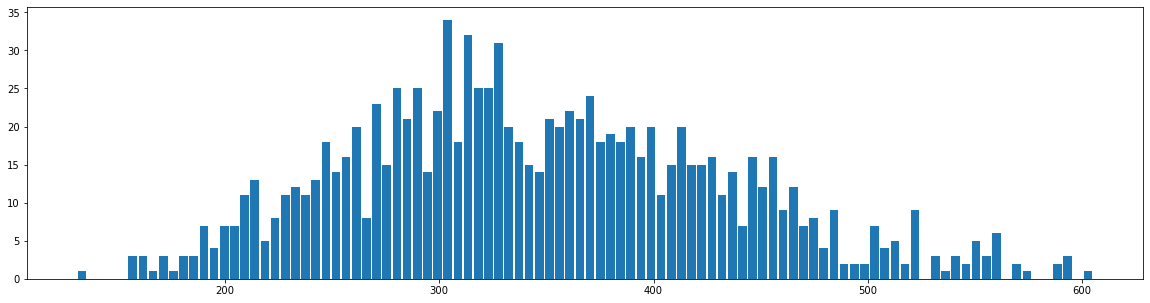

In [10]:
plt.figure(figsize=(20,5))
plt.hist(left['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

(array([ 3.,  0.,  5.,  1., 10., 20., 15., 17., 39., 27., 53., 29., 36.,
        41., 48., 38., 40., 36., 23., 36., 32., 35., 28., 36., 31., 24.,
        29., 18., 23., 20., 20., 16., 11.,  8.,  6., 13.,  7., 17., 13.,
        11.,  6., 13.,  6.,  9., 10., 10.,  8.,  4.,  2.,  5.,  4.,  7.,
         8.,  5.,  7.,  3.,  4.,  4.,  7.,  5.,  2.,  6.,  0.,  3.,  2.,
         2.,  5.,  2.,  5.,  3.,  1.,  1.,  1.,  4.,  1.,  2.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 66.  ,  68.89,  71.78,  74.67,  77.56,  80.45,  83.34,  86.23,
         89.12,  92.01,  94.9 ,  97.79, 100.68, 103.57, 106.46, 109.35,
        112.24, 115.13, 118.02, 120.91, 123.8 , 126.69, 129.58, 132.47,
        135.36, 138.25, 141.14, 144.03, 146.92, 149.81, 152.7 , 155.59,
        158.48, 161.37, 164.26, 167.15, 170.04, 172.93, 175.82, 178.71,
        181.6 , 184.49, 187.38, 190.27, 193.16, 196.05, 198.94, 201.83,
  

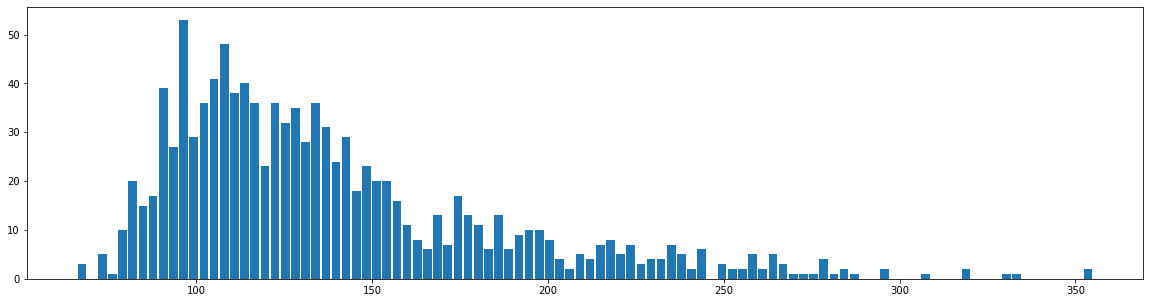

In [11]:
plt.figure(figsize=(20,5))
plt.hist(right['merged_all'].apply(lambda x: len(x)), bins=100, rwidth = .85)

# Prepping Data Indices

In [77]:
train_df = '/lfs/1/sahaana/enrichment/data/deepmatcher/abt_buy_exp_data/train_updated.csv'
train_df = pd.read_csv(train_df)

val_df = '/lfs/1/sahaana/enrichment/data/deepmatcher/abt_buy_exp_data/val_updated.csv'
val_df = pd.read_csv(val_df)

test_df = '/lfs/1/sahaana/enrichment/data/deepmatcher/abt_buy_exp_data/test_updated.csv'
test_df = pd.read_csv(test_df)

## Model H Params

In [182]:
epochs = 1
batch_size = 8
final_size = 200
lr = .00001
tl_margin = 1.0
tl_p = 2
pool_type = "CLS"
column = "merged_all"
shuffle = True
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_max_length = 512
compute_val = False

bert_path='/lfs/1/sahaana/enrichment/ember/pretraining/models/abt_buy_exp_data-uncased-masked-ALL-BM25'
bert_model = DistilBertModel.from_pretrained(bert_path, return_dict=True)

model_name = f'abt_buy_exp_data-uncased-masked-ALL-BM25'

## DataLoaders

In [183]:
train_data = DataLoader(DeepMatcherDataset(left, right, len(train_df), column, train_df), 
                        batch_size=batch_size,
                        shuffle = shuffle
                        )

val_data = DataLoader(DeepMatcherDataset(left, right, len(val_df), column, val_df), 
                       batch_size=batch_size,
                       shuffle = False
                      )

## Init and Run Model

In [184]:
triplet_loss = nn.TripletMarginLoss(margin=tl_margin, p=tl_p)
losses = []
val_losses = []
model = TripletSingleBERTModel(final_size, pool_type, bert_path)
optimizer = optim.AdamW(model.parameters(), lr=lr)#optim.SGD(model.parameters(), lr=lr)

In [185]:
save_dir = param_header(batch_size, final_size, lr, pool_type)
save_dir = f'models/{model_name}/{save_dir}/'

In [186]:
wandb.init(project=model_name)

Epoch,0
_step,718
_runtime,1098
_timestamp,1612948942
train batch loss,0.12293


Epoch,▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train batch loss,▆█▁▇▅▇▃▃▄▃▃▃▃▁▂▁▂▁▁▁▂▁▁▄▂▂▂▃▂▁▁▁▁▁▁▂▁▃▁▁


wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [187]:
train_model(model, 
            tokenizer, 
            tokenize_batch, 
            train_data, 
            val_data, 
            triplet_loss, 
            optimizer, 
            epochs, 
            losses, 
            val_losses, 
            save_dir, 
            compute_val, 
            tokenizer_max_length = tokenizer_max_length)

NameError: name 'os' is not defined

# k-NN Model Performance

In [188]:
#PATH = "models/single-tower-BERT-triplet-model/batch_size-8-final_size-50-opt_lr-0.0001-tloss_margin-1.0-tloss_p-2-pooling-CLS-shuffle-True00-35-05-01-21"
#model.load_state_dict(torch.load(PATH))

left_data = DataLoader(EmberEvalDataset(left, column), 
                       batch_size=batch_size,
                       shuffle = False
                      )
right_data = DataLoader(EmberEvalDataset(right, column), 
                       batch_size=batch_size,
                       shuffle = False
                      )

In [189]:
left_embeddings = eval_model(model, tokenizer, left_data, tokenizer_max_length=512)
right_embeddings = eval_model(model, tokenizer, right_data, tokenizer_max_length=512)

In [190]:
knn = FaissKNeighbors(k=30)
knn.fit(right_embeddings)
neib = knn.kneighbors(left_embeddings)

In [293]:
print(f"precision, recall, F1, support: {knn_top_1_PRFS(neib[0], neib[1], test_df)}")

precision, recall, F1, support: (0.9239130434782609, 0.8252427184466019, 0.8717948717948718, None)


In [219]:
np.where(neib[0][720] == np.min(neib[0][720]))

(array([0, 1, 2]),)

In [237]:
np.where(neib[0] == np.min(neib[0], axis=1)[:,None],)

(array([   0,    1,    2, ..., 1078, 1079, 1080]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [233]:
np.min(neib[0], axis=1)[:,None].shape

(1081, 1)

In [241]:
a, b = np.where(neib[0] == np.min(neib[0], axis=1)[:,None])

In [262]:
top_matches = defaultdict(set)
top_index = defaultdict(set)
for i,j in zip(a,b):
    top_matches[i].add(j)
    top_index[i].add(neib[1][i,j])

In [263]:
top_matches

defaultdict(set,
            {0: {0},
             1: {0},
             2: {0},
             3: {0},
             4: {0},
             5: {0},
             6: {0},
             7: {0},
             8: {0},
             9: {0},
             10: {0},
             11: {0},
             12: {0},
             13: {0},
             14: {0},
             15: {0},
             16: {0},
             17: {0},
             18: {0},
             19: {0},
             20: {0},
             21: {0},
             22: {0},
             23: {0},
             24: {0},
             25: {0},
             26: {0},
             27: {0},
             28: {0},
             29: {0},
             30: {0},
             31: {0},
             32: {0},
             33: {0},
             34: {0},
             35: {0},
             36: {0},
             37: {0},
             38: {0},
             39: {0},
             40: {0},
             41: {0},
             42: {0},
             43: {0},
             44: {0},
   

In [264]:
top_index

defaultdict(set,
            {0: {53},
             1: {657},
             2: {33},
             3: {195},
             4: {153},
             5: {191},
             6: {213},
             7: {161},
             8: {37},
             9: {179},
             10: {34},
             11: {35},
             12: {58},
             13: {197},
             14: {44},
             15: {56},
             16: {223},
             17: {845},
             18: {211},
             19: {40},
             20: {40},
             21: {196},
             22: {62},
             23: {491},
             24: {42},
             25: {21},
             26: {201},
             27: {47},
             28: {48},
             29: {43},
             30: {43},
             31: {643},
             32: {50},
             33: {198},
             34: {236},
             35: {199},
             36: {228},
             37: {316},
             38: {192},
             39: {984},
             40: {54},
             41: {811},
    

In [275]:
for i,j,k in train_df.to_numpy():
    print(i)
    break

730


In [ ]:

for k in range(30):
    print(k, *knn_matching_accuracy(neib[1], k, train_idx, test_idx))

In [168]:
test_df

,ltable_id,rtable_id,label
0,445,910,0
1,719,812,0
2,550,664,0
3,942,949,1
4,643,636,0
...,...,...,...
1911,522,936,0
1912,720,799,1
1913,385,454,0
1914,167,569,0


In [172]:
neib[1][720]

array([ 578, 1084, 1045,  774,  551,  610,  558,  780, 1041,  879,  799,
        801,  800,  184, 1015,  916,   35,  709,  217, 1026,  762,  460,
        878,  557,  798,  177,  773,  772,  763,  970])

In [174]:
left.loc[720]

id                                                           720
name           lg 2.0 cu . ft. over-the-range black microwave...
description    lg 2.0 cu . ft. over-the-range black microwave...
price                                                        NaN
merged_all      [SEP]  name lg 2.0 cu . ft. over-the-range bl...
Name: 720, dtype: object

In [181]:
right.loc[799]

id                                                           799
name                lg 2.0 cu.ft . over the range microwave oven
description                                                  NaN
price                                                        NaN
merged_all      [SEP]  name lg 2.0 cu.ft . over the range mic...
Name: 799, dtype: object

In [191]:
neib[1][720]

array([ 801,  799,  800,  780,  217,  787,  789,  788,  774,  783,  786,
        785,  784,  782,  773,  772,  766,  781,  423,  426,  779,  777,
        453,  765,  770,  768,  769,  767, 1045, 1084])

In [194]:
neib[0][720]

array([10.280792 , 10.280792 , 10.280792 , 10.359413 , 12.4604   ,
       13.335747 , 13.335747 , 13.335747 , 13.568726 , 14.973106 ,
       14.973106 , 14.973106 , 14.973106 , 14.973106 , 15.100166 ,
       15.118561 , 15.217945 , 15.246048 , 15.458317 , 15.641705 ,
       15.8689575, 15.987331 , 16.198994 , 16.24091  , 16.743385 ,
       16.743385 , 16.743385 , 16.74339  , 18.32719  , 18.65799  ],
      dtype=float32)

In [196]:
train_df[train_df['ltable_id'] == 720]

,ltable_id,rtable_id,label
823,720,1079,0
1118,720,780,0
1317,720,349,0
3376,720,800,0


In [197]:
test_df[test_df['ltable_id'] == 720]

,ltable_id,rtable_id,label
89,720,798,0
947,720,812,0
1190,720,811,0
1912,720,799,1


In [257]:
left.loc[719]['name'], left.loc[719]['description']

('lg 2.0 cu . ft. over-the-range white microwave oven lmvm2085wh',
 'lg 2.0 cu . ft. over-the-range white microwave oven lmvm2085wh warming lamp glide & spin sliding tray with turntable sensor cook feature 300 cfm exhaust system horizontal keypad elegant hidden vent wideview window halogen cooktop lighting white finish')

In [258]:
left.loc[722]['name'], left.loc[722]['description']

('lg 2.0 cu . ft. over-the-range stainless steel microwave oven lmvm2085ss',
 'lg 2.0 cu . ft. over-the-range stainless steel microwave oven lmvm2085ss warming lamp glide & spin sliding tray with turntable sensor cook feature 300 cfm exhaust system horizontal keypad elegant hidden vent wideview window halogen cooktop lighting stainless steel finish')

In [209]:
left.loc[720]['name'], left.loc[720]['description']

('lg 2.0 cu . ft. over-the-range black microwave oven lmvm2085bk',
 'lg 2.0 cu . ft. over-the-range black microwave oven lmvm2085bk warming lamp glide & spin sliding tray with turntable sensor cook feature 300 cfm exhaust system horizontal keypad elegant hidden vent wideview window halogen cooktop lighting black finish')

In [211]:
right.loc[799]['name'], right.loc[799]['description']

('lg 2.0 cu.ft . over the range microwave oven', nan)

In [212]:
right.loc[800]['name'], right.loc[800]['description']

('lg 2.0 cu.ft . over the range microwave oven', nan)

In [259]:
right.loc[801]['name'], right.loc[801]['description']

('lg 2.0 cu.ft . over the range microwave oven', nan)